# Optimization Experiments: Portfolio Optimization

This notebook implements and compares two optimization algorithms for portfolio optimization:
1. **Projected Gradient Descent (PGD) on Simplex**
2. **Penalty Gradient Descent**
3. **Augmented Lagrangian Method (ALM)**

## Problem Setup

We consider the portfolio optimization problem:

**Objective:** Minimize $\frac{1}{2} w^T \Sigma w - \lambda \mu^T w$

**Constraints:** 
- $w \geq 0$ (non-negative weights)
- $1^T w = 1$ (weights sum to 1)

Where:
- $w \in \mathbb{R}^n$ is the portfolio weight vector
- $\Sigma$ is the covariance matrix (risk)
- $\mu$ is the expected return vector
- $\lambda$ is the risk-aversion parameter


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import cvxpy as cp

# Set random seed for reproducibility
np.random.seed(42)


## 1. Generate Synthetic Test Data


In [3]:
# Parameters
n = 30  # number of assets
lambda_risk = 0.5  # risk-aversion parameter

# Generate random expected returns μ in [0.01, 0.2]
mu = np.random.uniform(0.01, 0.2, n)

# Generate covariance matrix Σ = A A^T + 0.1 I (PSD)
A = np.random.randn(n, n)
Sigma = A @ A.T + 0.1 * np.eye(n)

# Eigenvalues (symmetric PSD -> use eigvalsh)
eigvals = np.linalg.eigvalsh(Sigma)

print(f"Generated data for {n} assets")
print(f"μ range: [{mu.min():.4f}, {mu.max():.4f}]")
print(f"Σ is PSD (up to tol): {np.all(eigvals >= -1e-10)}")
print(f"Σ eigenvalues range: [{eigvals.min():.4f}, {eigvals.max():.4f}]")


Generated data for 30 assets
μ range: [0.0139, 0.1943]
Σ is PSD (up to tol): True
Σ eigenvalues range: [0.1035, 95.8025]


## 2. Algorithm 1: Projected Gradient Descent (PGD) on Simplex

**Objective:** $\frac{1}{2} w^T \Sigma w - \lambda \mu^T w$

**Gradient:** $\nabla f(w) = \Sigma w - \lambda \mu$

**Constraints:** $w \geq 0$, $1^T w = 1$

We use Euclidean projection onto the simplex to maintain feasibility.


In [4]:
def project_simplex(w):
    """Projection onto the probability simplex {w : w >= 0, 1^T w = 1}
    Implementation from Duchi et al. (2008).
    """
    n = len(w)
    u = np.sort(w)[::-1]
    cssv = np.cumsum(u)
    rho = np.where(u > (cssv - 1) / (np.arange(n) + 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(w - theta, 0.0)


def pgd_simplex(
    Sigma,
    mu,
    lambda_risk,
    w0=None,
    max_iter=1000,
    tol=1e-6,
    step_size=None,
):
    """
    Projected Gradient Descent for simplex-constrained mean-variance optimization.

    Minimizes:
        0.5 * w^T Sigma w − lambda_risk * mu^T w
    subject to:
        w >= 0,  sum(w) = 1
    """
    n = len(mu)

    # Initialize
    w = np.ones(n) / n if w0 is None else w0.copy()

    # Step size
    if step_size is None:
        L = np.linalg.eigvalsh(Sigma).max()
        step_size = 1.0 / max(L, 1e-12)

    # History
    obj_history = []
    feas_history = []
    grad_norm_history = []
    pg_map_norm_history = []

    for i in range(max_iter):
        # Gradient
        grad = Sigma @ w - lambda_risk * mu
        grad_norm_history.append(np.linalg.norm(grad))

        # PGD update
        w_next = project_simplex(w - step_size * grad)

        # Objective (log after update or before; either is fine—just be consistent)
        obj = 0.5 * w_next.T @ Sigma @ w_next - lambda_risk * mu.T @ w_next
        obj_history.append(obj)

        # Stationarity + feasibility
        pg_map = (w - w_next) / step_size
        pg_map_norm_history.append(np.linalg.norm(pg_map))

        feas = abs(w_next.sum() - 1.0)
        feas_history.append(feas)

        if feas < tol and np.linalg.norm(pg_map) < tol:
            w = w_next
            break

        w = w_next

    return {
        "w": w,
        "objective_history": np.array(obj_history),
        "feasibility_history": np.array(feas_history),
        "grad_norm_history": np.array(grad_norm_history),
        "pg_map_norm_history": np.array(pg_map_norm_history),
        "n_iters": i + 1,
        "step_size": step_size,
    }


In [5]:
def solve_cvxpy(Sigma, mu, lambda_risk):
    n = len(mu)
    Sigma = 0.5 * (Sigma + Sigma.T)  # enforce symmetry

    w = cp.Variable(n)
    objective = cp.Minimize(0.5 * cp.quad_form(w, Sigma) - lambda_risk * (mu @ w))
    constraints = [w >= 0, cp.sum(w) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, eps_abs=1e-8, eps_rel=1e-8, verbose=False)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise ValueError(f"Solver failed with status: {prob.status}")

    return w.value, float(prob.value)


In [6]:
res_pgd = pgd_simplex(Sigma, mu, lambda_risk)

w_pgd = res_pgd["w"]
obj_final = res_pgd["objective_history"][-1]
feas_final = res_pgd["feasibility_history"][-1]

print("PGD on Simplex Results:")
print(f"Final objective: {obj_final:.6f}")
print(f"Final constraint violation |1^T w - 1|: {feas_final:.10f}")
print(f"Final weights sum: {w_pgd.sum():.10f}")
print(f"Number of iterations: {res_pgd['n_iters']}")
print(f"Step size used: {res_pgd['step_size']:.6e}")
print(f"Final weights (first 5): {w_pgd[:5]}")


PGD on Simplex Results:
Final objective: 0.088348
Final constraint violation |1^T w - 1|: 0.0000000000
Final weights sum: 1.0000000000
Number of iterations: 387
Step size used: 1.043814e-02
Final weights (first 5): [0.01411486 0.00702767 0.10205967 0.         0.        ]


In [7]:
w_star, f_star = solve_cvxpy(Sigma, mu, lambda_risk)

gap = obj_final - f_star
w_diff = np.linalg.norm(w_pgd - w_star, 2)

print("CVXPY reference:")
print(f"Objective (CVXPY): {f_star:.6f}")
print(f"Objective gap (PGD - CVXPY): {gap:.3e}")
print(f"||w_pgd - w_star||_2: {w_diff:.3e}")


CVXPY reference:
Objective (CVXPY): 0.088348
Objective gap (PGD - CVXPY): 1.311e-13
||w_pgd - w_star||_2: 2.796e-07


In [8]:
def sharpe_ratio(returns, eps=1e-8):
    """
    Annualized Sharpe ratio assuming returns are monthly.
    """
    mean = np.mean(returns)
    std = np.std(returns) + eps
    return np.sqrt(12) * mean / std


def simulate_out_of_sample_experiment(
    mu_true,
    Sigma_true,
    lambda_risk,
    T_train=60,
    T_test=120,
    seed=0,
):
    """
    Runs a full in-sample vs out-of-sample mean-variance experiment.

    Steps:
    1. Generate training returns from true distribution
    2. Estimate mu_hat, Sigma_hat
    3. Optimize portfolio using estimates
    4. Generate new test returns from true distribution
    5. Compute in-sample and out-of-sample Sharpe
    """

    rng = np.random.default_rng(seed)
    n = len(mu_true)

    # --- 1. Simulate training (historical) returns ---
    R_train = rng.multivariate_normal(mu_true, Sigma_true, size=T_train)

    # --- 2. Estimate parameters from training data ---
    mu_hat = R_train.mean(axis=0)
    Sigma_hat = np.cov(R_train, rowvar=False)

    # --- 3. Optimize portfolio using estimated parameters ---
    result = pgd_simplex(Sigma_hat, mu_hat, lambda_risk)
    w_hat = result["w"]

    # --- 4. Simulate new future (test) returns ---
    R_test = rng.multivariate_normal(mu_true, Sigma_true, size=T_test)

    # --- 5. Portfolio returns ---
    train_portfolio_returns = R_train @ w_hat
    test_portfolio_returns = R_test @ w_hat

    # --- 6. Performance metrics ---
    sharpe_in = sharpe_ratio(train_portfolio_returns)
    sharpe_out = sharpe_ratio(test_portfolio_returns)

    weight_concentration = np.linalg.norm(w_hat, 2)

    return {
        "w_hat": w_hat,
        "sharpe_in_sample": sharpe_in,
        "sharpe_out_of_sample": sharpe_out,
        "weight_l2_norm": weight_concentration,
        "mu_hat": mu_hat,
        "Sigma_hat": Sigma_hat,
    }


In [9]:
experiment = simulate_out_of_sample_experiment(
    mu_true=mu,
    Sigma_true=Sigma,
    lambda_risk=lambda_risk,
    T_train=60,
    T_test=120,
    seed=42,
)

print("In-sample Sharpe:     ", experiment["sharpe_in_sample"])
print("Out-of-sample Sharpe: ", experiment["sharpe_out_of_sample"])
print("Weight L2 norm:       ", experiment["weight_l2_norm"])


In-sample Sharpe:      2.8225247275415146
Out-of-sample Sharpe:  0.4095834820393617
Weight L2 norm:        0.2843400393634934


### Algorithm 2: Penalty Gradient Descent

We replace the equality constraint with a quadratic penalty term:

$$
J_{\text{pen}}(w)
= \frac{1}{2} w^\top \Sigma w
- \lambda \mu^\top w
+ \lambda_p (1^\top w - 1)^2
$$

The gradient becomes:

$$
\nabla J_{\text{pen}}(w)
= \Sigma w - \lambda \mu
+ 2\lambda_p (1^\top w - 1)\mathbf{1}
$$

Unlike PGD, the equality constraint $1^\top w = 1$ is not enforced exactly.  
Instead, feasibility is achieved approximately and improves as $\lambda_p \to \infty$.

We project only onto the nonnegative orthant after each step:

$$
w \leftarrow \max(w, 0)
$$

This ensures $w \ge 0$, while the sum-to-one constraint is handled through the penalty term.


In [25]:
def penalty_gd(Sigma, mu, lambda_penalty, lambda_risk,
               w0=None, max_iter=2000, tol_pg=1e-3, tol_feas=1e-3, step_size=None):

    n = len(mu)
    ones = np.ones(n)

    w = np.ones(n)/n if w0 is None else np.maximum(w0.copy(), 0.0)

    if step_size is None:
        L = np.linalg.eigvalsh(Sigma).max() + 2.0 * lambda_penalty * n
        step_size = 1.0 / max(L, 1e-12)

    obj_true_history = []
    obj_penalty_history = []
    constraint_violation_history = []
    pg_map_norm_history = []

    for k in range(max_iter):
        sum_w = w.sum()
        viol = abs(sum_w - 1.0)
        constraint_violation_history.append(viol)

        obj_true = 0.5 * w.T @ Sigma @ w - lambda_risk * mu.T @ w
        obj_pen = obj_true + lambda_penalty * (sum_w - 1.0) ** 2
        obj_true_history.append(obj_true)
        obj_penalty_history.append(obj_pen)

        # stopping if objective stagnates
        if k > 10 and abs(obj_penalty_history[-1] - obj_penalty_history[-2]) < 1e-10:
            break

        grad = Sigma @ w - lambda_risk * mu + 2.0 * lambda_penalty * (sum_w - 1.0) * ones

        w_next = np.maximum(w - step_size * grad, 0.0)

        pg_map = (w - w_next) / step_size
        pg_norm = np.linalg.norm(pg_map)
        pg_map_norm_history.append(pg_norm)

        viol_next = abs(w_next.sum() - 1.0)

        if pg_norm < tol_pg and viol_next < tol_feas:
            w = w_next
            break

        w = w_next

    return {
        "w": w,
        "obj_true_history": np.array(obj_true_history),
        "obj_penalty_history": np.array(obj_penalty_history),
        "constraint_violation_history": np.array(constraint_violation_history),
        "pg_map_norm_history": np.array(pg_map_norm_history),
        "iterations": k + 1,
        "step_size": step_size,
    }


In [28]:
lambda_penalties = [10, 100, 1000]
results_penalty = {}

for lambda_p in lambda_penalties:
    if lambda_p == 10:
        max_iter = 10000
    elif lambda_p == 100:
        max_iter = 20000
    else:  # 1000
        max_iter = 11000

    res = penalty_gd(
        Sigma, mu, lambda_p, lambda_risk,
        max_iter=max_iter,
        tol_pg=1e-3,
        tol_feas=2e-3
    )

    results_penalty[lambda_p] = res

    w_pen = res["w"]
    obj_true_hist = res["obj_true_history"]
    obj_pen_hist = res["obj_penalty_history"]
    constraint_hist = res["constraint_violation_history"]
    iters = res["iterations"]

    print(f"\nPenalty GD (λ_p = {lambda_p}) Results:")
    print(f"  Final true objective:       {obj_true_hist[-1]:.6f}")
    print(f"  Final penalized objective:  {obj_pen_hist[-1]:.6f}")
    print(f"  Final constraint violation |1^T w - 1|: {constraint_hist[-1]:.10f}")
    print(f"  Final weights sum:          {w_pen.sum():.10f}")
    print(f"  Number of iterations:       {iters} (max_iter={max_iter})")
    print(f"  Hit max_iter cap?:          {iters == max_iter}")
    print(f"  Final pg-map norm:          {res['pg_map_norm_history'][-1]:.3e}")



Penalty GD (λ_p = 10) Results:
  Final true objective:       0.085895
  Final penalized objective:  0.087113
  Final constraint violation |1^T w - 1|: 0.0110391819
  Final weights sum:          0.9889608181
  Number of iterations:       1689 (max_iter=10000)
  Hit max_iter cap?:          False
  Final pg-map norm:          2.641e-04

Penalty GD (λ_p = 100) Results:
  Final true objective:       0.088098
  Final penalized objective:  0.088223
  Final constraint violation |1^T w - 1|: 0.0011176953
  Final weights sum:          0.9988823050
  Number of iterations:       12414 (max_iter=20000)
  Hit max_iter cap?:          False
  Final pg-map norm:          9.996e-04

Penalty GD (λ_p = 1000) Results:
  Final true objective:       0.099878
  Final penalized objective:  0.099894
  Final constraint violation |1^T w - 1|: 0.0001300275
  Final weights sum:          0.9998699744
  Number of iterations:       11000 (max_iter=11000)
  Hit max_iter cap?:          True
  Final pg-map norm:        

In [33]:
res_1000 = penalty_gd(Sigma, mu, 1000, lambda_risk, max_iter=50000)
print(res_1000["obj_true_history"][-1], res_1000["constraint_violation_history"][-1])


0.08920639810668332 0.000117589935097695


## **4. Algorithm 3: Augmented Lagrangian Method (ALM)**

The penalty method enforces the equality constraint $1^\top w = 1$ only indirectly. While increasing the penalty parameter $\lambda_p$ improves feasibility, it also **worsens numerical conditioning**, leading to slower convergence and potential loss of solution accuracy.

To mitigate this trade-off, we use the **Augmented Lagrangian Method (ALM)**, which combines:
- a **Lagrange multiplier** (dual variable) to enforce the constraint directly  
- a **moderate** quadratic penalty to stabilize the optimization  


### **Augmented Lagrangian Objective**

We define the augmented Lagrangian:

$$
\mathcal{L}_{\rho}(w, \nu)
=
\frac{1}{2} w^\top \Sigma w
- \lambda \mu^\top w
+ \nu (1^\top w - 1)
+ \frac{\rho}{2}(1^\top w - 1)^2
$$

where:
- $w \in \mathbb{R}^n$ are portfolio weights  
- $\nu \in \mathbb{R}$ is the Lagrange multiplier  
- $\rho > 0$ is the penalty parameter  

The non-negativity constraint $w \ge 0$ is enforced separately via projection.


### **Gradient with Respect to $w$**

$$
\nabla_w \mathcal{L}_{\rho}(w, \nu)
=
\Sigma w - \lambda \mu
+ \nu \mathbf{1}
+ \rho(1^\top w - 1)\mathbf{1}
$$


### **ALM Update Rules**

At iteration $k$:

**1. Primal update (projected gradient step):**

$$
w_{k+1}
=
\max\left(
w_k - \alpha \nabla_w \mathcal{L}_{\rho}(w_k,\nu_k),
0
\right)
$$

**2. Dual update (multiplier update):**

$$
\nu_{k+1}
=
\nu_k + \rho(1^\top w_{k+1} - 1)
$$


### **Stopping Criteria**

We monitor:
- stationarity via projected gradient norm  
- feasibility via $|1^\top w - 1|$  

ALM converges when both are sufficiently small.



In [29]:

def alm_gd(
    Sigma, mu, lambda_risk,
    rho=10.0,
    w0=None,
    nu0=0.0,
    max_outer=200,
    max_inner=200,
    tol_pg=1e-6,
    tol_feas=1e-6,
    step_size=None,
):
    """
    Augmented Lagrangian Method (ALM) with projected gradient descent inner steps.

    Problem:
        min  0.5 w^T Σ w - λ mu^T w
        s.t. w >= 0, 1^T w = 1

    Augmented Lagrangian:
        L_rho(w, nu) = 0.5 w^T Σ w - λ mu^T w
                      + nu(1^T w - 1) + (rho/2)(1^T w - 1)^2

    Inner loop:
        projected GD onto nonnegative orthant (w >= 0)

    Outer loop:
        dual update nu <- nu + rho(1^T w - 1)
    """
    Sigma = np.asarray(Sigma, dtype=float)
    mu = np.asarray(mu, dtype=float)
    n = len(mu)
    ones = np.ones(n)

    # init
    w = np.ones(n) / n if w0 is None else np.maximum(np.asarray(w0, dtype=float), 0.0)
    nu = float(nu0)

    # safe step size for inner GD (Lipschitz bound for grad wrt w)
    if step_size is None:
        L = np.linalg.eigvalsh(Sigma).max() + rho * n
        step_size = 1.0 / max(L, 1e-12)

    obj_hist = []
    feas_hist = []
    pg_map_hist = []
    nu_hist = []

    def true_obj(w_):
        return 0.5 * w_.T @ Sigma @ w_ - lambda_risk * mu.T @ w_

    for outer in range(max_outer):
        # ---- inner loop: approximately minimize L_rho(w, nu) over w>=0 ----
        for inner in range(max_inner):
            resid = w.sum() - 1.0

            # grad wrt w of augmented Lagrangian
            grad = Sigma @ w - lambda_risk * mu + (nu + rho * resid) * ones

            # projected step (nonnegativity only)
            w_next = np.maximum(w - step_size * grad, 0.0)

            pg_map = (w - w_next) / step_size
            pg_norm = np.linalg.norm(pg_map)

            w = w_next

            # optional early stop of inner loop
            if pg_norm < tol_pg:
                break

        # ---- diagnostics after inner loop ----
        resid = w.sum() - 1.0
        feas = abs(resid)
        obj = true_obj(w)

        obj_hist.append(obj)
        feas_hist.append(feas)
        pg_map_hist.append(pg_norm)
        nu_hist.append(nu)

        # ---- outer stopping ----
        if feas < tol_feas and pg_norm < tol_pg:
            break

        # ---- dual update ----
        nu = nu + rho * resid

    return {
        "w": w,
        "nu": nu,
        "objective_history": np.array(obj_hist),
        "feasibility_history": np.array(feas_hist),
        "pg_map_norm_history": np.array(pg_map_hist),
        "nu_history": np.array(nu_hist),
        "n_outer": outer + 1,
        "step_size": step_size,
        "rho": rho,
        "max_inner_used": max_inner,
    }


In [30]:
res_alm = alm_gd(
    Sigma, mu, lambda_risk,
    rho=10.0,          # start with moderate value
    max_outer=200,
    max_inner=200,
)

w_alm = res_alm["w"]


In [31]:
print("ALM Results:")
print(f"Final objective: {res_alm['objective_history'][-1]:.6f}")
print(f"Final constraint violation |1^T w - 1|: {res_alm['feasibility_history'][-1]:.10f}")
print(f"Final weights sum: {w_alm.sum():.10f}")
print(f"Outer iterations: {res_alm['n_outer']}")
print(f"Step size used: {res_alm['step_size']:.6e}")
print(f"Final weights (first 5): {w_alm[:5]}")


ALM Results:
Final objective: 0.088348
Final constraint violation |1^T w - 1|: 0.0000000035
Final weights sum: 1.0000000035
Outer iterations: 9
Step size used: 2.526513e-03
Final weights (first 5): [0.01411485 0.00702767 0.10205967 0.         0.        ]


In [39]:
dist_alm = np.linalg.norm(w_alm - w_pgd)

print("\nComparison to PGD:")
print(f"||w_alm - w_pgd||_2: {dist_alm:.6e}")
print(f"Objective gap: {res_alm['objective_history'][-1] - res_pgd['objective_history'][-1]:.6e}")



Comparison to PGD:
||w_alm - w_pgd||_2: 1.541504e-08
Objective gap: 7.862092e-10


## 4. Generate Plots


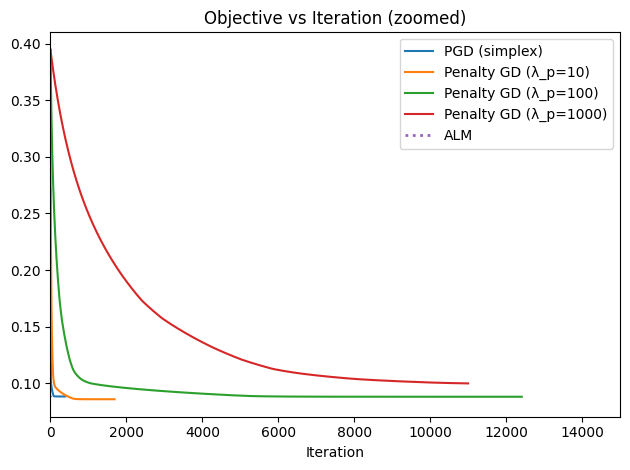

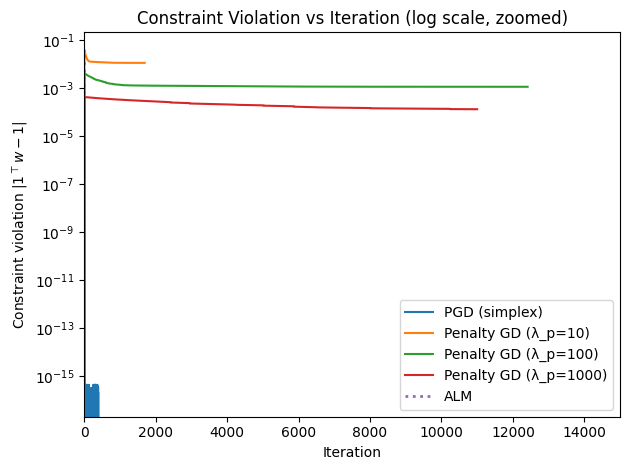

In [40]:
max_plot_iters = 15000

plt.figure()
plt.plot(res_pgd["objective_history"], label="PGD (simplex)")

for lambda_p in sorted(results_penalty.keys()):
    res = results_penalty[lambda_p]
    T = min(len(res["obj_true_history"]), max_plot_iters)
    plt.plot(res["obj_true_history"][:T], label=f"Penalty GD (λ_p={lambda_p})")

# ALM (only once, outside loop)
plt.plot(res_alm["objective_history"], linestyle=":", linewidth=2, label="ALM")

plt.xlabel("Iteration")
plt.title("Objective vs Iteration (zoomed)")
plt.xlim(0, max_plot_iters)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(res_pgd["feasibility_history"], label="PGD (simplex)")

for lambda_p in sorted(results_penalty.keys()):
    res = results_penalty[lambda_p]
    T = min(len(res["constraint_violation_history"]), max_plot_iters)
    plt.plot(res["constraint_violation_history"][:T], label=f"Penalty GD (λ_p={lambda_p})")

# ALM (ONLY ONCE, outside loop)
plt.plot(res_alm["feasibility_history"], linestyle=":", linewidth=2, label="ALM")

plt.xlabel("Iteration")
plt.ylabel(r"Constraint violation $|1^\top w - 1|$")
plt.title("Constraint Violation vs Iteration (log scale, zoomed)")
plt.xlim(0, max_plot_iters)
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()


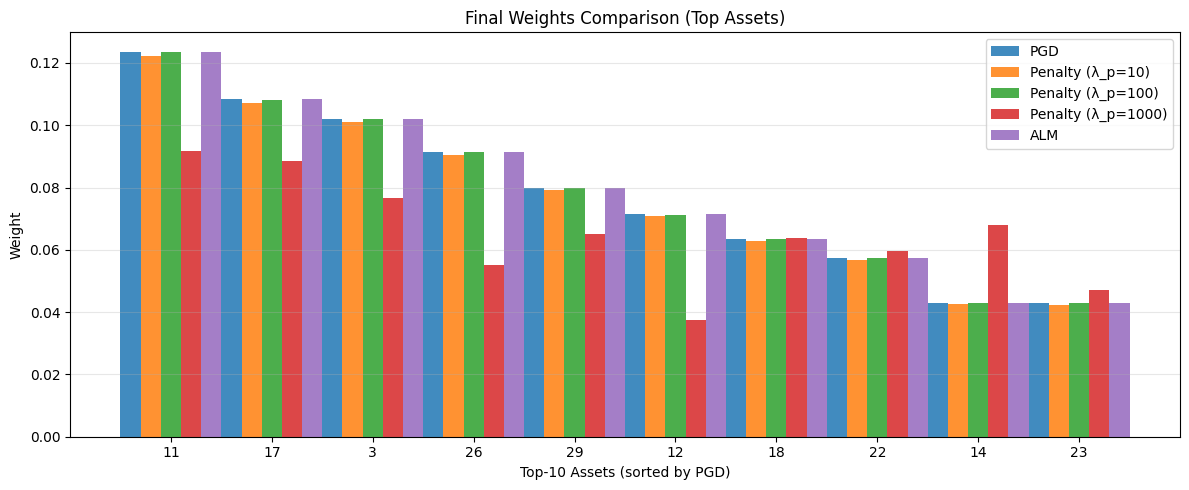

λ_p=10: 3.043e-03
λ_p=100: 4.968e-04
λ_p=1000: 9.728e-02
ALM: 1.542e-08


In [37]:
# Sort by PGD importance
idx = np.argsort(-w_pgd)
top_k = 10
idx = idx[:top_k]

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(top_k)
width = 0.2

ax.bar(x - 2*width, w_pgd[idx], width, label='PGD', alpha=0.85)
ax.bar(x - width, results_penalty[10]['w'][idx], width, label='Penalty (λ_p=10)', alpha=0.85)
ax.bar(x, results_penalty[100]['w'][idx], width, label='Penalty (λ_p=100)', alpha=0.85)
ax.bar(x + width, results_penalty[1000]['w'][idx], width, label='Penalty (λ_p=1000)', alpha=0.85)
ax.bar(x + 2*width, w_alm[idx], width, label='ALM', alpha=0.85)

ax.set_xlabel('Top-10 Assets (sorted by PGD)')
ax.set_ylabel('Weight')
ax.set_title('Final Weights Comparison (Top Assets)')
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}' for i in idx])
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

for lambda_p in [10, 100, 1000]:
    diff = np.linalg.norm(results_penalty[lambda_p]["w"] - w_pgd)
    print(f"λ_p={lambda_p}: {diff:.3e}")

print(f"ALM: {np.linalg.norm(w_alm - w_pgd):.3e}")


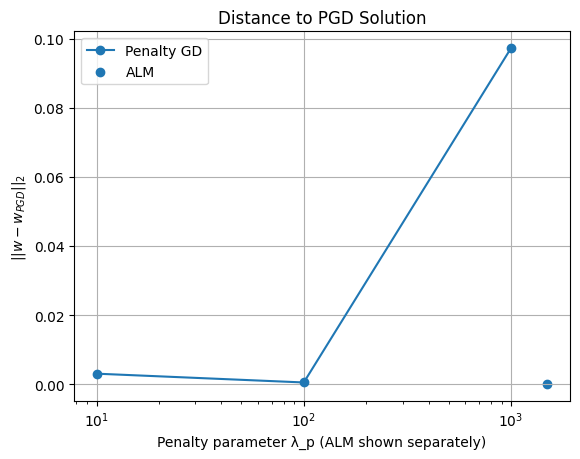

In [41]:
lambda_vals = [10, 100, 1000]

distances = [
    np.linalg.norm(results_penalty[l]["w"] - w_pgd)
    for l in lambda_vals
]

dist_alm = np.linalg.norm(w_alm - w_pgd)

plt.figure()
plt.plot(lambda_vals, distances, marker='o', label="Penalty GD")
plt.scatter([1500], [dist_alm], label="ALM")  # placed to the right

plt.xscale("log")
plt.xlabel("Penalty parameter λ_p (ALM shown separately)")
plt.ylabel(r"$||w - w_{PGD}||_2$")
plt.title("Distance to PGD Solution")
plt.legend()
plt.grid(True)
plt.show()


## 7. KKT Equivalence Demonstration

In this section, we use **CVXPY** to demonstrate the equivalence between three classical formulations
of mean–variance portfolio optimization when the parameters are chosen consistently:

1. **Scalarized problem (A):**
   
   Minimize $\tfrac{1}{2} w^T \Sigma w - \lambda_0 \mu^T w$  
   subject to $1^T w = 1$, $w \ge 0$.

2. **Target-return problem (B):**
   
   Minimize $\tfrac{1}{2} w^T \Sigma w$  
   subject to $\mu^T w = R_\star$, $1^T w = 1$, $w \ge 0$.

3. **Risk-budget problem (C):**
   
   Maximize $\mu^T w$  
   subject to $w^T \Sigma w \le \sigma_\star^2$, $1^T w = 1$, $w \ge 0$.

We first solve (A) to obtain $w_\star$, then define:

- $R_\star = \mu^T w_\star$ (optimal expected return)
- $\sigma_\star^2 = w_\star^T \Sigma w_\star$ (optimal variance)

Using these as parameters in (B) and (C), we show that their optimizers $w_{TR}$ and $w_{RB}$
are numerically identical to $w_\star$ (up to solver tolerance).


In [42]:

def solve_qp_or_raise(prob, name, solver=cp.OSQP, **kwargs):
    """Solve a QP (objective quadratic, constraints affine)."""
    prob.solve(solver=solver, verbose=False, **kwargs)
    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise ValueError(f"{name} failed with status: {prob.status}")
    return prob

def solve_conic_or_raise(prob, name, solver=None, **kwargs):
    """
    Solve a conic problem (e.g., quadratic constraint).
    Use SCS by default because it's commonly available.
    """
    if solver is None:
        solver = cp.SCS
    prob.solve(solver=solver, verbose=False, **kwargs)
    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise ValueError(f"{name} failed with status: {prob.status}")
    return prob

# -----------------------
# KKT equivalence via CVXPY
# -----------------------
lambda0 = lambda_risk
Sigma_sym = 0.5 * (Sigma + Sigma.T)  # numerical symmetry

# (A) Scalarized formulation
wA = cp.Variable(n)
objA = cp.Minimize(0.5 * cp.quad_form(wA, Sigma_sym) - lambda0 * (mu @ wA))
conA = [cp.sum(wA) == 1, wA >= 0]
probA = cp.Problem(objA, conA)
solve_qp_or_raise(probA, "Problem (A)", eps_abs=1e-9, eps_rel=1e-9)

w_star = wA.value
R_star = float(mu @ w_star)
sigma2_star = float(w_star.T @ Sigma_sym @ w_star)

print("KKT Equivalence Demonstration")
print("-" * 80)
print("Problem (A): Scalarized")
print(f"  status: {probA.status}")
print(f"  R_star (expected return): {R_star:.6f}")
print(f"  sigma2_star (variance):   {sigma2_star:.6f}")

# (B) Target-return formulation
wB = cp.Variable(n)
objB = cp.Minimize(0.5 * cp.quad_form(wB, Sigma_sym))
conB = [mu @ wB == R_star, cp.sum(wB) == 1, wB >= 0]
probB = cp.Problem(objB, conB)
solve_qp_or_raise(probB, "Problem (B)", eps_abs=1e-9, eps_rel=1e-9)

w_TR = wB.value

# (C) Risk-budget formulation (quadratic constraint -> conic)
wC = cp.Variable(n)
objC = cp.Maximize(mu @ wC)
eps_var = 1e-8
conC = [cp.sum(wC) == 1, wC >= 0, cp.quad_form(wC, Sigma_sym) <= sigma2_star + eps_var]
probC = cp.Problem(objC, conC)
solve_conic_or_raise(probC, "Problem (C)", solver=cp.SCS, eps=1e-6)

w_RB = wC.value

# Comparisons
norm_TR = np.linalg.norm(w_TR - w_star, 2)
norm_RB = np.linalg.norm(w_RB - w_star, 2)

print("\nProblem (B): Target-return")
print(f"  status: {probB.status}")
print(f"  ||w_TR - w_star||_2 = {norm_TR:.6e}")

print("\nProblem (C): Risk-budget")
print(f"  status: {probC.status}")
print(f"  ||w_RB - w_star||_2 = {norm_RB:.6e}")

if norm_TR < 1e-5 and norm_RB < 1e-5:
    print("\nConclusion: The three formulations match (up to solver tolerance).")
else:
    print("\nConclusion: Close but not identical (solver tolerance / slack / conditioning).")


KKT Equivalence Demonstration
--------------------------------------------------------------------------------
Problem (A): Scalarized
  status: optimal
  R_star (expected return): 0.094079
  sigma2_star (variance):   0.270775

Problem (B): Target-return
  status: optimal
  ||w_TR - w_star||_2 = 1.514262e-16

Problem (C): Risk-budget
  status: optimal
  ||w_RB - w_star||_2 = 2.865773e-07

Conclusion: The three formulations match (up to solver tolerance).
